In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as pltclr
import matplotlib.patches as patch
import skimage
from skimage.measure import label, regionprops, regionprops_table
import seaborn as sns

/tmp/ipykernel_28774/3837874603.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp
from utils.data67_processing import CellDataset, SubsetSampler

from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict
from utils.nb_utils import *


%load_ext autoreload
%autoreload 2
%matplotlib inline
import pprint

In [3]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler
np.random.seed(1)
torch.random.manual_seed(1)


image_directory  = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/'

model_name = 'protein1_datanormed_model_pfak2zyxin_aw_mse_corr_500ep'

modelinfo = torch.load('./tensorboard_logs/'+ model_name +'_0/model.pt',  map_location=torch.device(device))

dataset_kwargs = modelinfo['dataset_kwargs']

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])


crop_size = 1024
eval_dataset_kwargs = modelinfo['dataset_kwargs']
eval_dataset_kwargs['transform_kwargs']['crop_size'] = crop_size
eval_dataset_kwargs['transform_kwargs']['rotate'] = False
eval_dataset_kwargs['exclude_frames'] = None
dataset = dp.CellDataset( **eval_dataset_kwargs )

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)


for cell in ['cell_1','cell_2','cell_3','cell_4','cell_5','cell_6']:
    for frame in range(100):  
        
        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()

        print([zyx.max(),zyx.mean(),pax.max(),pax.mean()])


{'crop_size': 1024, 'output_channels': 6, 'norm_output': {'rescale': 1, 'threshold': 0.0004}, 'rotate': False}
[0.6744545, 0.004341222, 1.0, 0.012784708]
[1.0, 0.076943606, 1.0, 0.06895065]
[1.0, 0.028584661, 1.0, 0.048635375]
[1.0, 0.037395075, 1.0, 0.07429892]
[1.0, 0.02036089, 1.0, 0.03857943]
[0.883564, 0.008854963, 1.0, 0.027986478]
[1.0, 0.07577439, 1.0, 0.082314506]
[1.0, 0.06523454, 1.0, 0.08992873]
[1.0, 0.10821233, 1.0, 0.072037846]
[1.0, 0.14227322, 1.0, 0.11485479]
[1.0, 0.061042294, 1.0, 0.081858225]
[1.0, 0.07892166, 1.0, 0.09580144]
[1.0, 0.02686409, 1.0, 0.058834955]
[1.0, 0.019222392, 1.0, 0.047683492]
[1.0, 0.018250106, 1.0, 0.039112207]
[1.0, 0.017215608, 1.0, 0.03755404]
[1.0, 0.015525244, 1.0, 0.03797812]
[1.0, 0.01737951, 1.0, 0.03229859]
[1.0, 0.08417154, 1.0, 0.085375614]
[1.0, 0.04420878, 1.0, 0.06465411]
[1.0, 0.010891196, 1.0, 0.029547224]
[0.83128667, 0.016085176, 1.0, 0.050198507]
[1.0, 0.015742071, 1.0, 0.03138872]
[1.0, 0.013670583, 1.0, 0.040965587]
[1.0

KeyboardInterrupt: 

(array([8.96254e+05, 1.02186e+05, 3.03130e+04, 9.07200e+03, 4.06200e+03,
        2.22900e+03, 1.33400e+03, 7.84000e+02, 5.20000e+02, 1.82200e+03]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

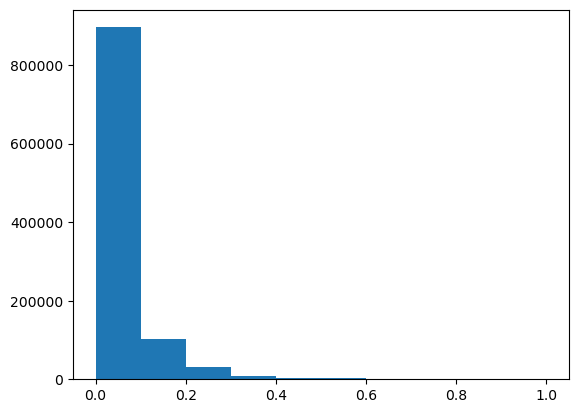

In [5]:
plt.hist(zyx[zyx>-1])